In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from pathlib import Path
import os
import glob
%matplotlib inline

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets,transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from matplotlib.animation import FuncAnimation

In [8]:
import nibabel as nib
from celluloid import Camera
from IPython.display import HTML
from tqdm.notebook import tqdm
import imgaug
from imgaug.augmentables.segmaps import SegmentationMapsOnImage
import imgaug.augmenters as iaa

In [33]:
hgg = glob.glob("D:\\Projects\\Brain_Tumor_ML\\brain_tumor_ML\\HGG\\Bra*\\*t1.nii*")
mask_hgg = glob.glob("D:\\Projects\\Brain_Tumor_ML\\brain_tumor_ML\\LGG\\Bra*\\*seg.nii*")

D:\Python\lib\site-packages\matplotlib\image.py:443: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
D:\Python\lib\site-packages\matplotlib\image.py:444: UserWarning: Warning: converting a masked element to nan.
  vmid = np.float64(self.norm.vmin) + dv / 2


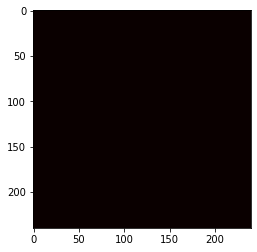

In [37]:
sample_path = hgg[40]
sample_path_label = mask_hgg[40]

data = nib.load(sample_path)
label = nib.load(sample_path_label)

mri = data.get_fdata()
mask = label.get_fdata().astype(np.uint8)

#  Plotting Sample Image
fig = plt.figure()
camera = Camera(fig)  # Create the camera object from celluloid

for i in range(mri.shape[2]):  # Sagital view
    plt.imshow(mri[:,:,i],cmap=plt.bone())
    mask_ = np.ma.masked_where(mask[:,:,i]==0, mask[:,:,i])
    plt.imshow(mask_, alpha=1, cmap=plt.hot())
    camera.snap()  # Store the current slice

animation = camera.animate(blit=False, interval=1) # Create the animation
animation.save('test2.gif')

In [38]:
# For Normalization of 3D Image
def normalize(full_volume):
    normal = (full_volume - full_volume.min()) / (full_volume.max() - full_volume.min())
    return normal

# For Standardization of 3D Image
def standardize(data):
    mu = data.mean()
    std = np.std(data)
    standard = (data - mu) / std
    return standard

In [42]:
# Preprocessing Image with train test split
save_root = Path("Preprocessed\HGG")

for j in range(len(hgg)):
    mri = nib.load(hgg[j])
    # assert nib.aff2axcodes(mri.affine) == ("R", "A", "S")    
    mri_data = mri.get_fdata()
    label_data = nib.load(mask_hgg[j]).get_fdata().astype(np.uint8)

    # Crop volume and label mask. Reduce 32 px from top and 32 px from bottom.
    # Addtionally crop front and back with same size. Dont crop viewing axis
    mri_data = mri_data[32:-32, 32:-32]
    label_data = label_data[32:-32, 32:-32]

    # Normalize and standardize the images
    normalized_mri_data = normalize(mri_data)
    standardized_mri_data = standardize(normalized_mri_data)

    if j<60:
        current_path = save_root/"train"/str(j)
    else:
        current_path = save_root/"test"/str(j)

    # Loop over the slices in the full volume and store the images and labels in the data/masks directory
    for i in range(standardized_mri_data.shape[-1]):
        slice = standardized_mri_data[:,:,i]
        mask = label_data[:,:,i]
        slice_path = current_path/"data"
        mask_path = current_path/"masks"
        slice_path.mkdir(parents=True, exist_ok=True)
        mask_path.mkdir(parents=True, exist_ok=True)
        
        np.save(slice_path/str(i), slice)
        np.save(mask_path/str(i), mask)

D:\Python\lib\site-packages\matplotlib\image.py:443: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
D:\Python\lib\site-packages\matplotlib\image.py:444: UserWarning: Warning: converting a masked element to nan.
  vmid = np.float64(self.norm.vmin) + dv / 2


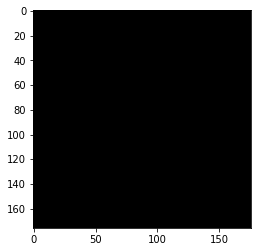

In [20]:
# Plotting Preprocessed Image

fig = plt.figure()
camera = Camera(fig)  # Create the camera object from celluloid

path = Path("Preprocessed/train/1/")  # Select a subject
for i in range(154):
    # Choose a file and load slice + mask
    file = str(i+1) + ".npy"
    slice = np.load(path/"data"/file)
    mask = np.load(path/"masks"/file)# Plot everything
    plt.imshow(slice, cmap="bone")
    mask_ = np.ma.masked_where(mask==0, mask)
    plt.imshow(mask_, cmap="autumn")
    camera.snap()
animate = camera.animate(blit=False, interval=1)
animate.save('prep.gif')

In [40]:
# Creating Dataset Class
class Dataset(torch.utils.data.Dataset):
    def __init__(self, root, augment_params):
        self.all_files = self.extract_files(root)
        self.augment_params = augment_params
    
    # Extract the paths to all slices given the root path (ends with train or val)
    @staticmethod
    def extract_files(root):
        files = []
        for subject in root.glob("*"):   # Iterate over the subjects
            slice_path = subject/"data"  # Get the slices for current subject
            for slice in slice_path.glob("*.npy"):
                files.append(slice)
        return files
    
    # Replace data with mask to get the masks    
    @staticmethod
    def change_img_to_label_path(path):

        parts = list(path.parts)
        parts[parts.index("data")] = "masks"
        return Path(*parts)

    # Augments slice and segmentation mask in the exact same way
    def augment(self, slice, mask):

        random_seed = torch.randint(0, 1000000, (1,)).item()
        imgaug.seed(random_seed)

        mask = SegmentationMapsOnImage(mask, mask.shape)
        slice_aug, mask_aug = self.augment_params(image=slice, segmentation_maps=mask)
        mask_aug = mask_aug.get_arr()
        return slice_aug, mask_aug
    
    # Return the length of the dataset (length of all files)
    def __len__(self):
        return len(self.all_files)
    
    # Given an index return the (augmented) slice and corresponding mask
    # Add another dimension for pytorch
    def __getitem__(self, idx):

        file_path = self.all_files[idx]
        mask_path = self.change_img_to_label_path(file_path)
        slice = np.load(file_path).astype(np.float32)  # Convert to float for torch
        mask = np.load(mask_path)
        
        if self.augment_params:
            slice, mask = self.augment(slice, mask)

        return np.expand_dims(slice, 0), np.expand_dims(mask, 0)

In [41]:
# Transformation
seq = iaa.Sequential([
    iaa.Affine(scale=(0.85, 1.15), # Zoom in or out
               rotate=(-45, 45)),  # Rotate up to 45 degrees
    iaa.ElasticTransformation()  # Random Elastic Deformations
                ])

In [63]:
# Create the dataset objects
train_path = Path("Preprocessed/train/")
test_path = Path("Preprocessed/test")

train_dataset = Dataset(train_path, seq)
test_dataset = Dataset(test_path, None)

In [64]:
batch_size = 8
num_workers = 4

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)